In [1]:
# Import System packages
import sys 
import ROOT 
import glob 
import numpy as np 
import pandas as pd 
import array
import pandas as pd
import os
import cppyy
import matplotlib.pyplot as plt
import awkward as ak
import matplotlib.pyplot as plt

# Load Custom Libraries
sys.path.insert(0,"/eos/user/t/tpeacock/Software/analysisTools/")
sys.path.insert(0,"/eos/user/t/tpeacock/Software/hk-BONSAI/python/")

import pyBONSAI
import pyWCTEAnalysisTools
from pyWCTEAnalysisTools import *

# Setup the default directories and create a BONSAI object
pyBONSAI.set_default_directories(
    WCSIM_BUILD_DIR="/eos/user/t/tpeacock/Software/WCSim-develop/build/",
    BONSAIDIR="/eos/user/t/tpeacock/Software/hk-BONSAI/",
    BONSAIPARAM="./alt_param_wcte.dat"
)
bonsai = pyBONSAI.WCTE_hkBONSAI()

BONSAI ENV
 - WCSIM_BUILD_DIR =  /eos/user/t/tpeacock/Software/WCSim-develop/build/
 - BONSAIDIR =  /eos/user/t/tpeacock/Software/hk-BONSAI/
 - BONSAIPARAM =  ./alt_param_wcte.dat
 Geometry Loading (NPMT=1995) 
Loaded 1995 PMT locations, maximum r=157.713089, maximum z=138.848557
reading ./alt_param_wcte.dat...
BONSAI and Clusfit Shared Parameters
-------------------------------------------------------
PMT time resolution:                           1.00 ns
PMT coincidence time difference:               1.00 ns
PMT pair maximal distance fraction:            0.1785
PMT pair maximal time difference fraction:     0.1079
Maximum # of hits to do all 4-hit combin.:    12
Initial grid constant:                        50.00 cm
Minimum wall distance for 4-hit vertices:     50.00 cm

Clusfit Parameters
-------------------------------------------------------
Clusfit grid constant:                        50.00 cm
Minimum wall distance for Clusfit vertex:     10.00 cm
Initial Clusfit Cherenkov cone 

/tmp/ipykernel_2414/2967701929.py:192: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


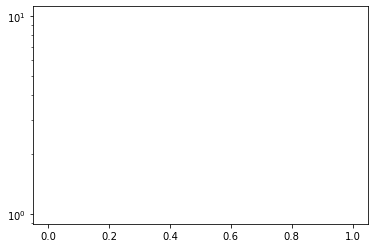

In [2]:
ff = get_offline_run_files(1771)


# Start Filter
ns = 1
count = 0
nhit_cut = 10
mvwindow_start =   10000*ns
mvwindow_end   = 5000000*ns
mvwindow_step  =      10*ns
mvwindow_width =      50*ns

vertex = {
"nhits": [],
"nhitso": [],
"x": [],
"y": [],
"z": [],
"result0": [],
"result1": [],
"result2": [],
"result3": [],
"result4": [],
"result5": [],
"good0":[],
"good1":[],
"good2":[] 
}

hitslist = {
        "x":[],
        "y":[],
        "z":[],
        "q":[],
        "t":[]
}

shortlist = []
longlist = []
psdlist = []

import uproot

geo = get_geo_mapping()
# Run Bonsai
bsVertex = array.array('f',3*[0.0])
bsResult = array.array('f',6*[0.0])
bsGood = array.array('f',3*[0.0])
bsNsel = array.array('i',[0])
bsNhit = array.array('i',[0])

minhits = 20
geo = get_geo_mapping()

    

branches=[
    "hit_pmt_calibrated_times",
    "hit_pmt_has_time_constant",
    "hit_pmt_charges",
    "hit_mpmt_card_ids",
    "hit_mpmt_slot_ids",
    "hit_pmt_channel_ids",
    "hit_pmt_position_ids"
]

class readoutwindow:
    def __init__(self):
        self.valid = False

def getwindows(chunk, branches):
    nwindows = len(chunk[branches[0]])
    
    hit_pmt_has_time_constant = chunk["hit_pmt_has_time_constant"]
    hit_pmt_calibrated_times = chunk["hit_pmt_calibrated_times"]
    
    rwlist= []
    for i in range(nwindows):
        rw = readoutwindow()
        
        mask = hit_pmt_has_time_constant[i] > 0
        order = ak.argsort( hit_pmt_calibrated_times[i][mask] )

        for attr in branches:            
            setattr(rw, attr, chunk[attr][i][mask][order])
                
        rw.valid = True
        rwlist.append(rw)
        
    return rwlist
        

def get_n50window(w,nhits=0):
    
    startidx = 0
    endidx = 0
    hittimes = w.hit_pmt_calibrated_times
    nmax = len(hittimes)
    
    mask = w.cables > 0
    w.hit_pmt_calibrated_times = w.hit_pmt_calibrated_times[mask]
    w.hit_pmt_charges = w.hit_pmt_charges[mask]
    w.cables = w.cables[mask]
    
    
    windows = []
    i = 0
    while i < nmax:
        
        startidx = i
        starttime = hittimes[startidx]
        
        for j in range(i,nmax-1):
            endidx = j
            endtime = hittimes[endidx+1]
        
            if (endtime - starttime) > 50:
                break
        i += 1
        
        if nhits < (endidx - startidx):
            rwn = readoutwindow()
            rwn.hit_pmt_calibrated_times = hittimes[startidx:endidx]
            rwn.cables = w.cables[startidx:endidx]
            rwn.hit_pmt_charges = w.hit_pmt_charges[startidx:endidx]
            
            windows.append(rwn)
            
            i = endidx
        
    return windows
    

lookupc = np.load("WCSIM_CABLE_MAP.npy")


from tqdm import tqdm

nhitlist = []
for chunk in uproot.iterate(get_offline_run_base(1771)+":WCTEReadoutWindows", 
                             branches, library="np", step_size=1000):
    
    windows = getwindows(chunk, branches)   
    break
    
    
    for w in tqdm(windows):
        
        # Map cables
        w.lookupids = w.hit_mpmt_slot_ids*100 + w.hit_pmt_channel_ids
        w.cables = lookupc[w.lookupids].astype(np.uint32)
        
        n50windows = get_n50window(w, minhits)
        for n50window in n50windows:
            if len(n50window.hit_pmt_calibrated_times) > 1000: continue
                          
            bsCAB_a = array.array('i', n50window.cables)
            bsT_a = array.array('f', n50window.hit_pmt_calibrated_times - np.mean(n50window.hit_pmt_calibrated_times)+100)
            bsQ_a = array.array('f', n50window.hit_pmt_charges)
            bsNhit = array.array('i',[len(n50window.hit_pmt_charges)])

            # Run Bonsai
            try:
                nhits = bsNhit[0]
                nhits_bonsai = bonsai.BonsaiFit(bsVertex, bsResult, bsGood, bsNsel, bsNhit, bsCAB_a, bsT_a, bsQ_a);
            except:
                pass
            
            
            vertex["nhits"].append(nhits)
            vertex["nhitso"].append(nhits_bonsai)

            vertex["x"].append(bsVertex[0])
            vertex["y"].append(bsVertex[1])
            vertex["z"].append(bsVertex[2])
            vertex["result0"].append(bsResult[0])
            vertex["result1"].append(bsResult[1])
            vertex["result2"].append(bsResult[2])
            vertex["result3"].append(bsResult[3])
            vertex["result4"].append(bsResult[4])
            vertex["result5"].append(bsResult[5])
            vertex["good0"].append(bsGood[0])
            vertex["good1"].append(bsGood[1])
            vertex["good2"].append(bsGood[2])
            
# #         print("NEXT - WINDOW")
#     break
    
plt.hist(nhitlist, bins=100)
plt.yscale('log')
plt.show()    

In [3]:
w = windows[0]

In [28]:
print(np.unique(w.hit_pmt_channel_ids))
print(np.unique(w.hit_mpmt_card_ids))



print(np.unique(w.hit_mpmt_slot_ids))
print(np.unique(w.hit_pmt_position_ids))

print("WC")
print(np.unique(geo.mpmtid))
print(np.unique(geo.spmtid))
print(np.unique(geo.id))

cablemap = np.zeros(10619)

for mpmtid in range(106):
    for spmtid in range(19):
        uniqueid = mpmtid*100 + spmtid
        print(mpmtid, spmtid, uniqueid)
        cablemap[uniqueid] = 
        


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[  1   3   6   7   8  10  11  12  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  38  40  41  42  43
  44  45  46  47  48  52  71  73  74  75  76  77  78  79  80  82  83  84
  85  86  87  89  91  92  93  94  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 111 112 113 114 115 117 118]
[  0   1   2   3   4   5   6   7   8  10  11  13  19  20  21  22  23  24
  25  26  28  29  30  31  33  34  35  36  37  38  39  40  41  43  44  46
  47  49  50  51  52  53  54  55  56  57  58  60  61  62  64  65  66  68
  69  70  71  72  73  75  76  78  80  81  82  83  84  86  87  88  89  90
  92  93  94  95  97  98 100 101 103 104 105]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
WC
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  46  47  48  49  

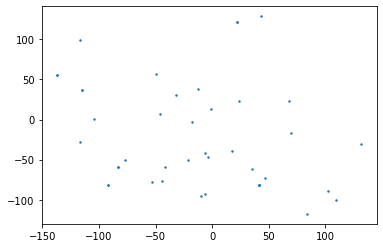

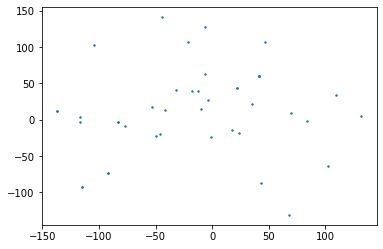

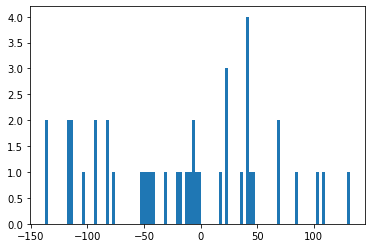

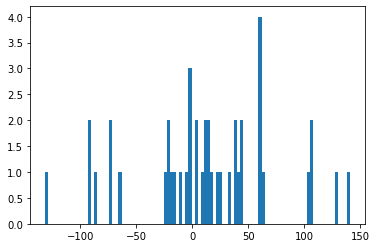

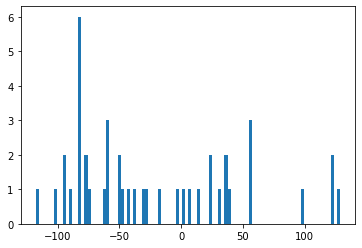

In [12]:
df = pd.DataFrame(vertex)
plt.scatter(df.x, df.z,  s=2)
plt.show()

plt.scatter(df.x, df.y,  s=2)
plt.show()

plt.hist(df.x,bins=100)
plt.show()

plt.hist(df.y,bins=100)
plt.show()

plt.hist(df.z,bins=100)
plt.show()
